In [ ]:
#!pip install wandb
!pip install -q kaggle
#!wandb login

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 611M/612M [00:28<00:00, 23.6MB/s]
100% 612M/612M [00:28<00:00, 22.3MB/s]


In [ ]:
!unzip \*.zip -d inp  && rm *.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: inp/train/5/00005_00053_00010.png  
  inflating: inp/train/5/00005_00053_00011.png  
  inflating: inp/train/5/00005_00053_00012.png  
  inflating: inp/train/5/00005_00053_00013.png  
  inflating: inp/train/5/00005_00053_00014.png  
  inflating: inp/train/5/00005_00053_00015.png  
  inflating: inp/train/5/00005_00053_00016.png  
  inflating: inp/train/5/00005_00053_00017.png  
  inflating: inp/train/5/00005_00053_00018.png  
  inflating: inp/train/5/00005_00053_00019.png  
  inflating: inp/train/5/00005_00053_00020.png  
  inflating: inp/train/5/00005_00053_00021.png  
  inflating: inp/train/5/00005_00053_00022.png  
  inflating: inp/train/5/00005_00053_00023.png  
  inflating: inp/train/5/00005_00053_00024.png  
  inflating: inp/train/5/00005_00053_00025.png  
  inflating: inp/train/5/00005_00053_00026.png  
  inflating: inp/train/5/00005_00053_00027.png  
  inflating: inp/train/5/00005_00053_00028.png  
  

In [ ]:
import wandb
from fastai.vision.all import *
from fastai.callback.wandb import *

In [ ]:
epos = 20
lr = 0.1

In [ ]:
wandb.init(
    project="traffic-sign",
    config={
        "learning_rate": lr,
        "architecture": "resnet",
        "dataset": "gtsrb-german-traffic-sign",
        "epochs": epos,
    }
)

In [ ]:
df = pd.read_csv('./inp/Train.csv')
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [ ]:
print(f'Number of classes: {df.ClassId.unique().shape[0]}')

Number of classes: 43


In [ ]:
print(f'Number of images: {df.Path.unique().shape[0]}')

Number of images: 39209


In [ ]:
dftest = pd.read_csv('./inp/Test.csv')
dftest.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [ ]:
print(f'Number of images: {dftest.Path.unique().shape[0]}')

Number of images: 12630


In [ ]:
labels = ['20 km/h',
          '30 km/h',
          '50 km/h',
          '60 km/h',
          '70 km/h',
          '80 km/h',
          '80 km/h end',
          '100 km/h',
          '120 km/h',
          'No overtaking',
          'No overtaking for trucks',
          'Crossroad with secondary way',
          'Main road',
          'Give way',
          'Stop',
          'Road up',
          'Road up for truck',
          'No entry',
          'Other dangerous',
          'Turn left',
          'Turn right',
          'Winding road',
          'Hollow road',
          'Slippery road',
          'Narrowing road',
          'Roadwork',
          'Traffic light',
          'Pedestrian',
          'Children',
          'Bike',
          'Snow',
          'Deer',
          'End of the limits',
          'Only right',
          'Only left',
          'Only straight',
          'Only straight and right',
          'Only straight and left',
          'Take right',
          'Take left',
          'Circle crossroad',
          'End of overtaking limit',
          'End of overtaking limit for truck']

df['Label'] = df['ClassId'].replace(sorted(df['ClassId'].unique()), labels)

df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Label
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,Turn right
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,Turn right
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,Turn right
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,Turn right
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,Turn right


In [ ]:
dls = ImageDataLoaders.from_df(df, fn_col='Path', label_col='Label', path='./inp/', seed=42, item_tfms=Resize(256))

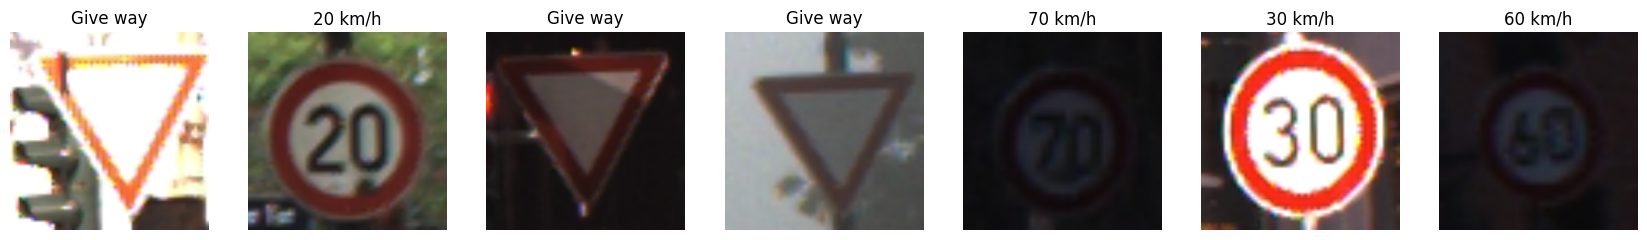

In [ ]:
dls.train.show_batch(max_n=7, nrows=1)

In [ ]:
learn = vision_learner(dls, resnet34, lr=lr, metrics=[error_rate, accuracy],
                    cbs=WandbCallback(log="all",
                                      log_preds=True,
                                      log_preds_every_epoch=True,
                                      log_model=True,
                                      log_dataset=True))

log_dataset("./inp","gtsrb-german-traffic-sign")

learn.fit(epos, lr)

wandb.finish()

wandb: Adding directory to artifact (/content/inp/Meta)... Done. 0.0s
wandb: Adding directory to artifact (/content/inp/meta)... Done. 0.0s
wandb: Adding directory to artifact (/content/inp/test)... Done. 5.9s
wandb: Adding directory to artifact (/content/inp/Train)... Done. 18.6s
wandb: Adding directory to artifact (/content/inp/train)... Done. 18.5s
wandb: Adding directory to artifact (/content/inp/Test)... Done. 6.2s
wandb: Adding directory to artifact (/content/inp/Meta)... Done. 0.0s
wandb: Adding directory to artifact (/content/inp/meta)... Done. 0.0s
wandb: Adding directory to artifact (/content/inp/test)... Done. 6.1s
wandb: Adding directory to artifact (/content/inp/Train)... Done. 19.1s
wandb: Adding directory to artifact (/content/inp/train)... Done. 18.3s
wandb: Adding directory to artifact (/content/inp/Test)... Done. 6.4s


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.951325,5.673101,0.657952,0.342048,02:42
1,4.429685,17.481667,0.335161,0.664839,02:44
2,3.247214,28.934553,0.273435,0.726565,02:41
3,3.839502,33.681316,0.151001,0.848999,02:41
4,4.009701,1369.829712,0.093611,0.906389,02:41
5,5.124242,5181.260742,0.268588,0.731412,02:42
6,3.786831,7.925302,0.141691,0.858309,02:41
7,5.622888,4.849170,0.051141,0.948859,02:42
8,2.755895,68.726593,0.043234,0.956766,02:40
9,3.686388,338.486267,0.093738,0.906262,02:41


Better model found at epoch 0 with valid_loss value: 5.67310094833374.
Better model found at epoch 7 with valid_loss value: 4.849169731140137.
Better model found at epoch 12 with valid_loss value: 1.5002166032791138.


accuracy,▁▅▅▇▇▅▇██▇▇██▇██████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▄▄▂▂▄▂▁▁▂▂▁▁▂▁▁▁▁▁▁
lr_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
